This sample demonstrates celebrity face classification using Keras with transfer learning

In [1]:
import os
# print(os.listdir("../input"))
# print(os.listdir("../input/keras-pretrained-models/"))

data_dir = 'C:\\Users\\utkarsh\\OneDrive\\Desktop\\CV\\Assignment_2'
vgg16weight = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#resnet50weight = './resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [2]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K
import tensorflow as tf
import keras

import matplotlib.pyplot as plt

### 1. Prepare Data

In [3]:
img_width, img_height = 200, 200

train_data_dir = os.path.join(data_dir, 'train/')
validation_data_dir = os.path.join(data_dir, 'val/')
nb_train_samples = 93
nb_validation_samples = 25
epochs = 50
batch_size = 16
numclasses = 5

In [4]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


### 2. Model

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [6]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
        
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model
 
def resnet50tl(input_shape, outclass, sigma='sigmoid'):
    
    base_model = None
    base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model.load_weights(resnet50weight)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    return model


In [7]:
model = vgg16CNNtl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\utkarsh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 3. Train

In [11]:
for i in range(2):
    history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
    model.save('model_kg_'+str(i+1)+'.h5')

Epoch 1/10
5/5 [==============================] - 85s 15s/step - loss: 2.0806 - accuracy: 0.2078 - val_loss: 1.4604 - val_accuracy: 0.3125
Epoch 2/10
5/5 [==============================] - 64s 13s/step - loss: 1.7746 - accuracy: 0.2857 - val_loss: 1.5943 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 69s 13s/step - loss: 1.6474 - accuracy: 0.2987 - val_loss: 1.5371 - val_accuracy: 0.3750
Epoch 4/10
5/5 [==============================] - 62s 12s/step - loss: 1.6012 - accuracy: 0.2857 - val_loss: 1.5148 - val_accuracy: 0.3125
Epoch 5/10
5/5 [==============================] - 62s 12s/step - loss: 1.5354 - accuracy: 0.3896 - val_loss: 1.5508 - val_accuracy: 0.3750
Epoch 6/10
5/5 [==============================] - 66s 13s/step - loss: 1.4666 - accuracy: 0.3896 - val_loss: 1.3856 - val_accuracy: 0.6875
Epoch 7/10
5/5 [==============================] - 65s 13s/step - loss: 1.4587 - accuracy: 0.4026 - val_loss: 1.5025 - val_accuracy: 0.3125
Epoch 8/10
5/5 [===========

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

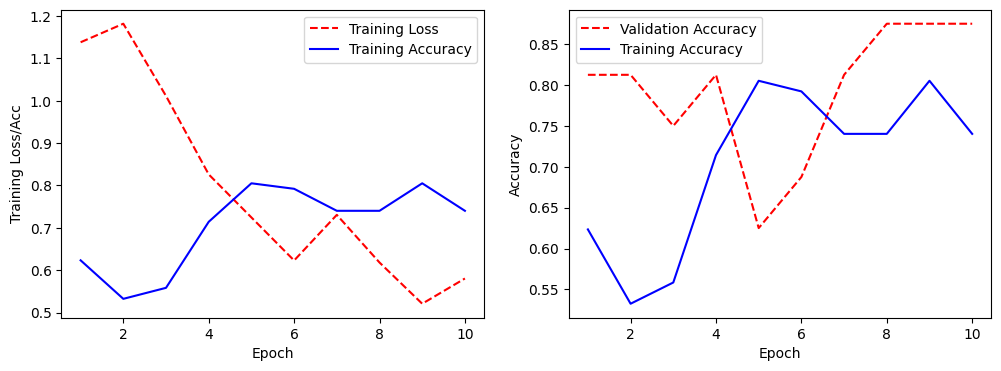

In [13]:
# model.save('model.h5')
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [14]:
saveweight =  'celebriytag_weight.h5'
model.save_weights(saveweight)

### 4. Evaluation

In [15]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

1/1 [==============================] - 0s 491ms/step


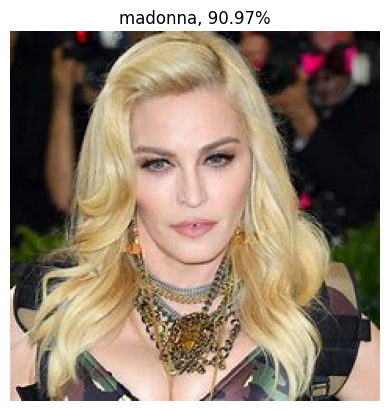

In [31]:
import tensorflow.keras.preprocessing.image as image
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
test_imgs = ['Madona.jpeg','Ben_Afleck.jpeg']
# jerry.jpg ,madonna.jpg, mindy.jpg
for test in test_imgs:
    test_img = os.path.join(validation_data_dir, test)
    img = tf.keras.preprocessing.image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)
    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)
plt.show()

    #print("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))